In [94]:
#Весь важный код с Титаника
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

In [95]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:50% !important;height:70% !important}</style>"
HTML(style)

<AxesSubplot:xlabel='max_depth', ylabel='score'>

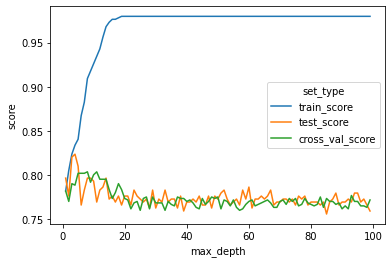

In [96]:
titainc_data = pd.read_csv('train.csv')
X = titainc_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis = 1)
y = titainc_data.Survived
X = pd.get_dummies(X)
X = X.fillna({'Age': X.Age.median()})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)
scores_data = pd.DataFrame()
# Grid search CV своими руками
for max_depth in range(1,100):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    temp_score_data = pd.DataFrame({'max_depth':[max_depth], 'train_score':[train_score], 'test_score':[test_score], 'cross_val_score':[mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars =['train_score', 'test_score', 'cross_val_score'], var_name='set_type', value_name = 'score')
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [97]:
max_score = scores_data_long.query(("set_type == 'cross_val_score'")).score.max()
# Ура, нашли лучшую глубину
scores_data_long.query("score == @max_score")

,max_depth,set_type,score
205,8,cross_val_score,0.803725


In [98]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6)
cross_val_score(best_clf, X_test, y_test, cv=5).mean()

0.8203389830508474

In [99]:
clf = tree.DecisionTreeClassifier()
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [100]:
from sklearn.model_selection import GridSearchCV
# Штука для тюна параметров
clf = tree.DecisionTreeClassifier()
parameters = {'criterion':['gini', 'entropy'], 'max_depth':range(1, 100)}

In [101]:
grid_search_cv_clf = GridSearchCV(clf, param_grid = parameters, cv =5)

In [102]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 100)})

In [103]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 10}

In [104]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf.score(X_test, y_test)

0.8033898305084746

In [105]:
y_pred = best_clf.predict(X_test)
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_pred)

0.8229166666666666

In [106]:
recall_score(y_test, y_pred)

0.6583333333333333

<AxesSubplot:>

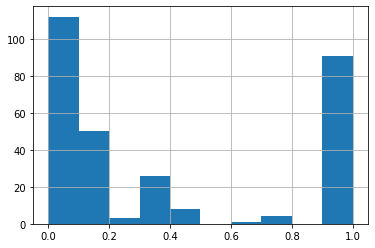

In [107]:
y_predicted_prob = best_clf.predict_proba(X_test)
pd.Series(y_predicted_prob[:,1]).hist()

In [108]:
y_pred = np.where(y_predicted_prob[:,1] > 0.8, 1, 0)
precision_score(y_test, y_pred)

0.8351648351648352

In [109]:
recall_score(y_test, y_pred)

0.6333333333333333

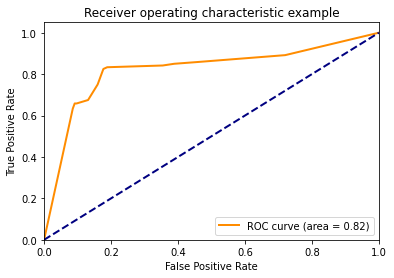

In [110]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
lw = 2
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()